In [89]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
import poppy
import timeit
from scipy.special import erfc

# Propogate Divergence & Waist Rays of Gaussian Beamlets - NONastigmatic beamlets

# Wavefront Parameters
wl = 2.2e-6  # wavelength
OF = 1.5 # beamlet overlap factor
N  = 1 # Number of beamlets to trace    

# Generate Poppy aperture
amax = 5e-3     # meters
ap = poppy.CircularAperture(radius=amax)

# Detector Parameters
sample = 512       # number of detector pixels across

# Calculate Gaussian Beamlet Parameters
wo = amax*OF/(2*N)
print(wo,'mm beam waist')
print(wo/wl,'waves beam waist')

zr = np.pi*wo**2/wl # rayleigh range
k  = 2*np.pi/wl # wave number

# System Parameters
d   = .9*zr     # propagation distance
f   = 1e50    # focal length
n   = 1       # refractive index 

0.00375 mm beam waist
1704.5454545454545 waves beam waist


In [90]:
# Generate fibbonacci spaced list of xy center rays
r = amax
c = np.array([0,0]) # XY offset from a spiral
R = r*np.sqrt(np.linspace(1/2,N-1/2,N))/np.sqrt(N-1/2)
T = 4/(1+np.sqrt(5))*np.pi*np.linspace(1,N,N);
X = c[0] +R*np.cos(T)
Y = c[1] +R*np.sin(T)
print(X)

[-0.00368684]


In [91]:
# Define a Q Matrix - diagonal zero for nonastigmatic case
qxx = 1/(1j*zr)
qxy = 0
qyx = 0
qyy = 1/(1j*zr)
Q = np.array([[qxx,qxy],
             [qyx,qyy]],dtype='complex') # Defines the matrix of inverse q parameters
print('Qmat = ',Q)

Qmat =  [[0.-0.04979781j 0.+0.j        ]
 [0.+0.j         0.-0.04979781j]]


In [92]:
# Define 4x4 system Matrix - off diagonal parameters relevant for astigmatic systems
A = np.array([[(1-d/f),0],
              [0,(1-d/f)]])
B = np.array([[d,0],
              [0,d]])
C = np.array([[(d/f -2)/f,0],
              [0,(d/f -2)/f]])
D = A

# Concatenate 2x2 elements into 4x4
J = np.array([[A,B],
              [C,D]])

print('System Mat = ',J)

System Mat =  [[[[ 1.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  1.00000000e+00]]

  [[ 1.80730827e+01  0.00000000e+00]
   [ 0.00000000e+00  1.80730827e+01]]]


 [[[-2.00000000e-50  0.00000000e+00]
   [ 0.00000000e+00 -2.00000000e-50]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  1.00000000e+00]]]]


In [93]:
print(J[0,1])

[[18.07308274  0.        ]
 [ 0.         18.07308274]]


In [94]:
# Define Gaussian & Half-Gaussian Beamlet w/Qprop

def Qprop(J,Q):
    
    # Prepare complex curvature matrix
    Qn = (C + np.matmul(D,Q)) # matrix numerator
    Qd = np.linalg.inv(A + np.matmul(B,Q)) # matrix denominator
    Qp = np.matmul(Qn,Qd) # propagated complex curvature
    
    return Qp

def GauBlet(J,Qp,Q,u,v):
    
    # Set up Electric Field Expression with detector dimensions
    u,v = np.meshgrid(u,v)
    Gamp = np.exp(-1j*k*d)/np.sqrt(np.linalg.norm(A+np.matmul(B,Q)))
    rQmult = Qp[0,0]*u**2 + (Qp[0,1]+Qp[1,0])*u*v + Qp[1,1]*v**2
    Gphase = np.exp((-1j*k/2)*rQmult)
    Efield = Gamp*Gphase
    Ifield = np.real(Efield*np.conj(Efield))
    
    return Ifield

def HGauBlet(J,Qp,Q,u,v):
    
    # Set up Electric Field Expression with detector dimensions
    A = J[0,0]
    B = J[0,1]
    u,v = np.meshgrid(u,v)
    Gamp = np.exp(-1j*k*d)/np.sqrt(np.linalg.norm(A+np.matmul(B,Q)))
    rQmult = Qp[0,0]*u**2 + (Qp[0,1]+Qp[1,0])*u*v + Qp[1,1]*v**2
    Gphase = np.exp((-1j*k/2)*rQmult)
    Hgaubamp = .5*erfc(-np.sqrt((1j*k)/(2*B[0,0]*(A[0,0] + B[0,0]*Q[0,0])))*u)
    Efield = Gamp*Gphase*Hgaubamp
    Ifield = np.real(Efield*np.conj(Efield))
    
    return Ifield
    

In [97]:
u = np.linspace(-amax,amax,sample)
v = u
Qp = Qprop(J,Q)

# Set up Electric Field Expression with detector dimensions
A = J[0,0]
B = J[0,1]
u,v = np.meshgrid(u,v)
Gamp = np.exp(-1j*k*d)/np.sqrt(np.linalg.norm(A+np.matmul(B,Q)))
rQmult = Qp[0,0]*u**2 + (Qp[0,1]+Qp[1,0])*u*v + Qp[1,1]*v**2
Gphase = np.exp((-1j*k/2)*rQmult)
Hgaubamp = .5*erfc(np.sqrt((1j*k)/(2*B[0,0]*(A[0,0] + B[0,0]*Q[0,0])))*u)
Efield = Gamp*Gphase*Hgaubamp
Ifield = np.real(Efield*np.conj(Efield))


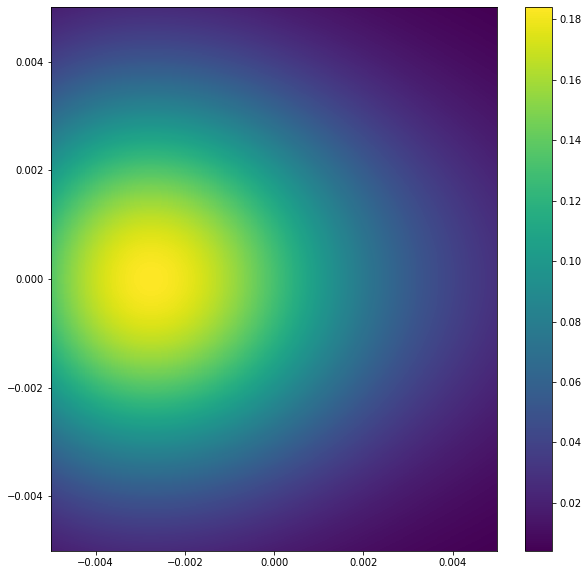

In [98]:
plt.figure(figsize=[10,10])
plt.pcolor(u,v,Ifield)
plt.colorbar()

In [86]:
# Propagation loop, trace base ray and q-parameter

# prepare array of base rays
base = np.array([[X],
                 [Y],
                 [0*X],
                 [0*Y]])

# prepare system matrix
focus = np.array([[1,0,0,0],
                  [0,1,0,0],
                  [-1/f,0,1,0],
                  [0,-1/f,0,1]])

propg = np.array([[1,0,d,0],
                 [0,1,0,d],
                 [0,0,1,0],
                 [0,0,0,1]])

system = np.matmul(propg,focus)

# propagate X and Y projections of rays
#x_ray = base*X
#y_ray = base*Y
#x_prp = np.matmul(system,x_ray)
#y_prp = np.matmul(system,y_ray)

#tbox = np.sqrt(np.square(x_prp[0,:]-x_ray[0,:])+np.square(y_prp[0,:]-y_ray[0,:])+d**2)
prop = (np.matmul(system,base[:,0]))
tbox = np.sqrt(np.square(prop[0,:]-base[0,:]) + np.square(prop[1,:]-base[1,:]) + d**2)

# propagate Q Parameter
Qp = Qprop(system,Q)
A = system[0:2,0:2]
B = system[0:2,2:4]

In [87]:
u = np.linspace(-amax,amax,sample)
v = u

# for loop evaluation of electric field
Ifield = np.zeros([sample,sample],dtype=float)
for eval_ind in range(N):
    # Set up Electric Field Expression with detector dimensions
    A = J[0,0]
    B = J[0,1]
    U,V = np.meshgrid(u-prop[0,eval_ind],v-prop[1,eval_ind])
    Gamp = np.exp(-1j*k*d)/np.sqrt(np.linalg.norm(A+np.matmul(B,Q)))
    rQmult = Qp[0,0]*np.square(U) + (Qp[0,1]+Qp[1,0])*U*V + Qp[1,1]*np.square(V)
    Gphase = np.exp((-1j*k/2)*rQmult)
    Hgaubamp = .5*erfc(-np.sqrt((1j*k)/(2*B[0,0]*(A[0,0] + B[0,0]*Q[0,0])))*U)
    Efield = Gamp*Gphase*Hgaubamp
    Ifield = Ifield+ np.real(Efield*np.conj(Efield))
    

C:\Users\Jaren\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


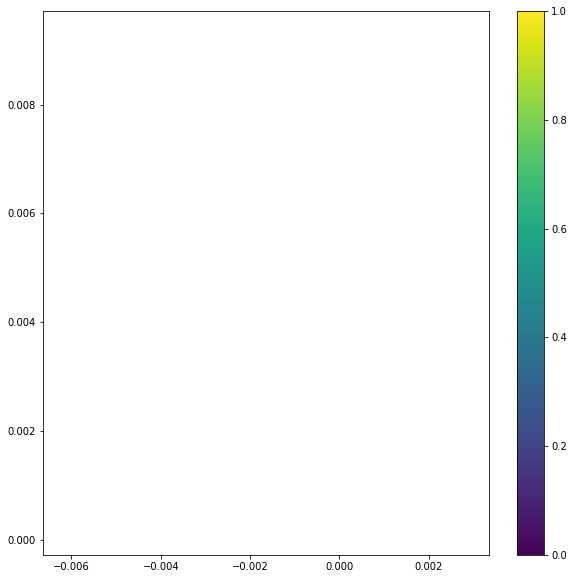

In [88]:
plt.figure(figsize=[10,10])
plt.pcolor(U,V,Ifield)
plt.colorbar()